# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

In [5]:
!conda install -c conda-forge -y librosa

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



In [1]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange

# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [260]:
def load_mel(file_name, start=0, stop=None, n_mels=60):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 6000, fmax = 9000)
#     spectrogram = stats.boxcox(spectrogram, lmbda=0.043, alpha=0.000001)

#     mfccs = librosa.feature.mfcc(S=spectrogram, norm='ortho', dct_type=3)
#     return mfccs
    return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram

def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = [file_name for file_name in os.listdir('test') if file_name.endswith('.wav')]
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)

def load_test_2(load_repr=load_mel, interval=0.3, step=0.05):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    compartment = interval / 2
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = [file_name for file_name in os.listdir('test') if file_name.endswith('.wav')]
    recordings_ids = []
    print('samples:', samples)
    for file_name in tqdm(rec_files):
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            for i in np.arange(t + compartment, t + 1 - compartment, step): 
                representation = load_repr(os.path.join('test', file_name), start = i - compartment, stop = i + compartment)
                X_test.append(representation)
                recordings_ids.append((recording_id, t))
    return np.array(X_test), recordings_ids


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('train') if file_name.endswith('.wav')]
    print(rec_files)
    for file_name in rec_files:
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        y_binary = map_seconds_to_y(recording_labels)
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('train', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
    return np.array(X_train), np.array(y_train)

def prepare_training_set(labels, interval):
    starts, stops, y_binary = [], [], []
    compartment = interval / 2
    # creating positive samples 
    for label in labels:
        middle = label[1] + (label[2] - label[1]) / 2 
        start = middle - compartment
        starts.append(start)
        stop = middle + compartment
        stops.append(stop)
        if start < 0 or stop > 10:
            y_binary.append(-1)
        else: 
            y_binary.append(1)
    # creating negative samples
    loop_counter = len(labels) 
    while loop_counter:
        middle = torch.FloatTensor(1).uniform_(compartment, 10 - compartment).numpy()
        start = middle - compartment 
        stop = middle + compartment
        check = np.zeros(len(starts))
        for i in range(len(starts)):
            if start > stops[i] or stop < starts[i]:
                check[i] = 1
            else:
                check[i] = 0
        if np.all(check):
            loop_counter -= 1
            starts.append(start)
            stops.append(stop)
            y_binary.append(0)
            
    return starts, stops, y_binary

def load_train_2(load_repr=load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('train') if file_name.endswith('.wav')]
    for file_name in tqdm(rec_files):
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
#         print('recording labels:', recording_labels)
        starts, stops, y_binary = prepare_training_set(recording_labels, 0.3)
#         print("starts:", starts)
#         print("stops:", stops)
        assert len(starts) == len(stops) == len(y_binary)
        for start, stop, y in zip(starts, stops, y_binary):
            if y != -1:
                try:
    #                 print('start:',start)
    #                 print('stop:',stop)
    #                 print('filename:',file_name)
                    representation = load_repr(os.path.join('train', file_name), start=start, stop=stop)
                    X_train.append(representation)
                    y_train.append(y)
    #                 print(X_train[0].shape)
    #                 print(y_train[0])
                except ValueError as e:
                    print('Error reading file', file_name)
                    print(e)
                except TypeError as e:
                    print('Unsupported type', file_name)
                    print(e)
    return np.array(X_train), np.array(y_train)

In [25]:
a = []
a.append([])

In [14]:
a[-1].append(1)

In [27]:
a[-1].append(1)

In [28]:
a

[[1]]

In [18]:
a.append([])
a[-1].append(1)


In [20]:

a[-1].append(1)

In [21]:
a

[[1], [], [], [1, 1]]

In [24]:
np.array(a)

array([list([1]), list([]), list([]), list([1, 1])], dtype=object)

In [10]:
for i in np.arange(0.15,1,0.1):
    print(i)

0.15
0.25
0.35
0.45
0.55
0.65
0.75


# Zapisywanie Wczytanej Reprezentacji

Ponieważ tworzenie reprezentacji może zabierać sporo czasu (szczególnie w tak naiwnej implementacji jak powyższa), warto zapisać wczytane dane do plików.

In [731]:
print(os.getcwd())
print(os.listdir("."))

/home/michal/Studia/2_semester/nnSolutions/nn2019/2_kaggle_birds_sounds/data
['helpers.ipynb', 'sampleSubmission.csv', 'train', 'tmp_model.pt', 'submission.csv', 'tmp_preds.npy', 'test', '.ipynb_checkpoints']


In [732]:
import librosa.core.logamplitude

ModuleNotFoundError: No module named 'librosa.core.logamplitude'

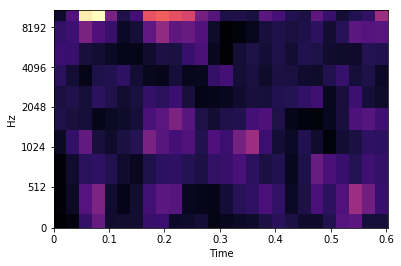

In [207]:
import librosa.display
spec = load_mel(os.path.join(os.getcwd(), 'train','rec25.wav'),start=9.1, stop=9.4)
# spec = librosa.power_to_db(spec,ref=5.0)
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

In [772]:
mfccs = librosa.feature.mfcc(S=spec, norm='ortho', dct_type=3)

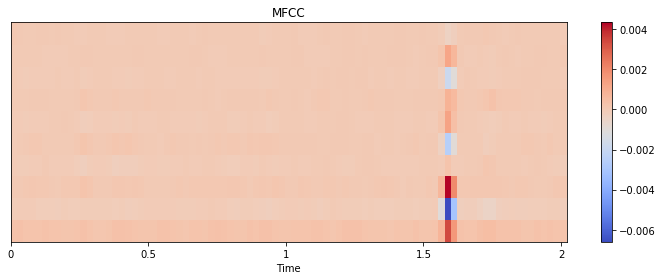

In [773]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [766]:
mfccs.shape

(10, 87)

In [476]:
spec.shape

(10, 87)

In [463]:
spec.shape

(10, 87)

In [261]:
# Poniższa linijka ustawia folder główny
# os.chdir('../input/')

X_test, recordings_ids = load_test_2(interval=0.3, step=0.1)
# np.save(os.path.join('test', 'tmp_X_test'), X_test)

X, y = load_train_2()
# np.save(os.path.join('train', 'tmp_X_train'), X)
# np.save(os.path.join('train', 'tmp_y_train'), y)



  0%|          | 0/175 [00:00<?, ?it/s]

samples: [['1' '1']
 ['1' '2']
 ['1' '6']
 ..., 
 ['175' '5']
 ['175' '8']
 ['175' '9']]




  1%|          | 1/175 [00:00<02:12,  1.31it/s]

  1%|          | 2/175 [00:01<02:02,  1.41it/s]

  2%|▏         | 3/175 [00:01<01:51,  1.54it/s]

  2%|▏         | 4/175 [00:02<01:44,  1.64it/s]

  3%|▎         | 5/175 [00:02<01:38,  1.73it/s]

  3%|▎         | 6/175 [00:03<01:43,  1.64it/s]

  4%|▍         | 7/175 [00:04<01:47,  1.56it/s]

  5%|▍         | 8/175 [00:04<01:40,  1.66it/s]

  5%|▌         | 9/175 [00:05<01:35,  1.74it/s]

  6%|▌         | 10/175 [00:05<01:30,  1.82it/s]

  6%|▋         | 11/175 [00:06<01:27,  1.87it/s]

  7%|▋         | 12/175 [00:06<01:25,  1.91it/s]

  7%|▋         | 13/175 [00:07<01:23,  1.94it/s]

  8%|▊         | 14/175 [00:07<01:23,  1.93it/s]

  9%|▊         | 15/175 [00:08<01:22,  1.94it/s]

  9%|▉         | 16/175 [00:08<01:22,  1.92it/s]

 10%|▉         | 17/175 [00:09<01:21,  1.94it/s]

 10%|█         | 18/175 [00:09<01:20,  1.94it/s]

 11%|█         | 19/175 [00:10<01:19,  1.95it/s]

 11%|█▏        | 20/175 [00:10<01:19,  1.96it/s]

 12%|█▏

 83%|████████▎ | 146/175 [01:32<00:16,  1.79it/s]

 84%|████████▍ | 147/175 [01:32<00:15,  1.85it/s]

 85%|████████▍ | 148/175 [01:33<00:16,  1.68it/s]

 85%|████████▌ | 149/175 [01:34<00:15,  1.72it/s]

 86%|████████▌ | 150/175 [01:34<00:14,  1.73it/s]

 86%|████████▋ | 151/175 [01:35<00:15,  1.57it/s]

 87%|████████▋ | 152/175 [01:36<00:15,  1.51it/s]

 87%|████████▋ | 153/175 [01:36<00:13,  1.57it/s]

 88%|████████▊ | 154/175 [01:37<00:12,  1.62it/s]

 89%|████████▊ | 155/175 [01:38<00:12,  1.54it/s]

 89%|████████▉ | 156/175 [01:38<00:12,  1.49it/s]

 90%|████████▉ | 157/175 [01:39<00:11,  1.54it/s]

 90%|█████████ | 158/175 [01:40<00:10,  1.64it/s]

 91%|█████████ | 159/175 [01:40<00:10,  1.59it/s]

 91%|█████████▏| 160/175 [01:41<00:09,  1.55it/s]

 92%|█████████▏| 161/175 [01:42<00:09,  1.53it/s]

 93%|█████████▎| 162/175 [01:42<00:08,  1.50it/s]

 93%|█████████▎| 163/175 [01:43<00:08,  1.47it/s]

 94%|█████████▎| 164/175 [01:44<00:09,  1.18it/s]

 94%|█████████▍| 165/175 [01:45

 96%|█████████▌| 346/361 [00:18<00:00, 21.07it/s]

 97%|█████████▋| 350/361 [00:18<00:00, 24.36it/s]

 98%|█████████▊| 353/361 [00:18<00:00, 23.54it/s]

 99%|█████████▊| 356/361 [00:18<00:00, 18.74it/s]

 99%|█████████▉| 359/361 [00:18<00:00, 18.89it/s]

100%|██████████| 361/361 [00:18<00:00, 19.08it/s]

In [264]:
X_test.shape

(6730, 60, 26)

In [121]:
recordings_ids


[('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 1),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 2),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 6),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 7),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('170', 9),
 ('18', 0),
 ('18', 0),
 ('18', 0),
 ('18', 0),
 ('18', 0),
 ('1

In [134]:

X_test_native = load_test()

In [137]:
X_test_native.shape

(924, 10, 87)

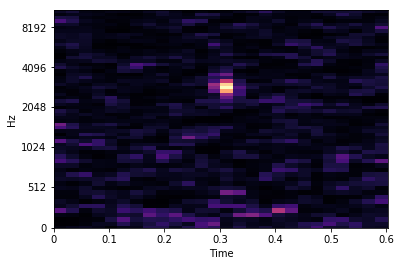

In [289]:

librosa.display.specshow(X[11], y_axis='mel', x_axis='time')

In [290]:
y[11]

1

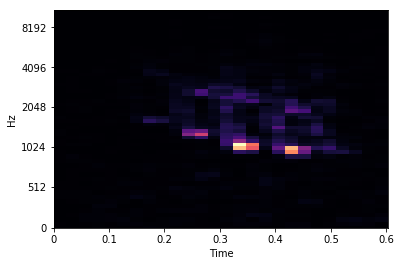

In [298]:
import librosa.display
spec = load_mel(os.path.join(os.getcwd(), 'test','rec21.wav'),start=6.7, stop=7, n_mels=60)
# spec = librosa.power_to_db(spec,ref=5.0)
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

In [40]:
X_test[1][0].shape

(10, 26)

In [ ]:
X_test_native

In [61]:
X.shape

(959, 10, 26)

In [42]:
np.save(os.path.join('test', 'tmp_X_test'), X_test)
np.save(os.path.join('train', 'tmp_X_train'), X)
np.save(os.path.join('train', 'tmp_y_train'), y)

In [63]:
X_test = np.load(os.path.join(os.getcwd(), 'test', 'tmp_X_test.npy'))
X = np.load(os.path.join(os.getcwd(), 'train', 'tmp_X_train.npy'))
y = np.load(os.path.join(os.getcwd(), 'train', 'tmp_y_train.npy'))

In [112]:
y[4]

1

In [65]:
X.shape

(959, 10, 26)

In [51]:
import librosa.display

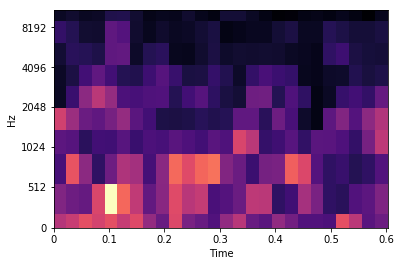

In [201]:
librosa.display.specshow(X_test[137], y_axis='mel', x_axis='time')


In [10]:
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(X[120]), n_mfcc=20, dct_type=3)


In [11]:
mfccs.shape

(10, 87)

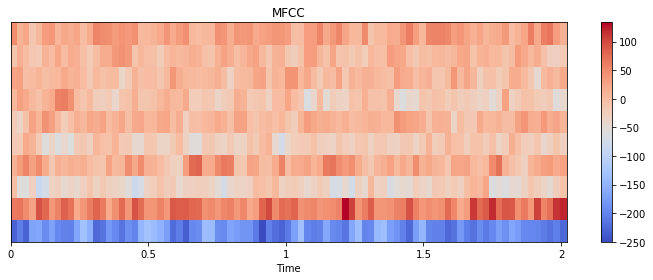

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

# Model i Trenowanie

Poniższy przykład używa poprawnych metryk i zapisuje parametry modelu.

In [550]:
# class Detector(torch.nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.linear = torch.nn.Linear(10 * 87, 2)
    
#     def forward(self, x):
#         out = torch.flatten(x, start_dim = 1)
#         out = self.linear(out)
#         return out
    
# clf = Detector()

In [3]:

X_test = np.load(os.path.join(os.getcwd(), 'test', 'tmp_X_test.npy'))
X = np.load(os.path.join(os.getcwd(), 'train', 'tmp_X_train.npy'))
y = np.load(os.path.join(os.getcwd(), 'train', 'tmp_y_train.npy'))

import torch
class ConvNet(torch.nn.Module):
    
    def __init__(self, block):
        super(ConvNet, self).__init__()
        
        # wstępna warstwa konwolucyjna + ReLU
        self.conv = torch.nn.Conv2d(1, 8, kernel_size=(1,10))
        self.relu = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(8)
        
        # (mikroarchitektura + max pooling) x 2
#         self.block1 = block(16, 32)
#         self.pool1 = torch.nn.MaxPool2d((1,10))
#         self.block2 = block(32, 64)
        self.pool2 = torch.nn.MaxPool2d((1,10))
        
        # warstwa w pełni połączona po "rozprostowaniu" obrazu do postaci wektora
        self.dense = torch.nn.Linear(560, 2)
    
    def forward(self, x):
        log = False 
        if log:
            print(x.shape)
        out = self.relu(self.batch_norm1(self.conv(x)))
        if log:
            print(out.shape)
#         out = self.block1(out)
#         if log:
#             print(out.shape)
#         out = self.pool1(out)
#         if log:
#             print(out.shape)
#         out = self.block2(out)
#         if log:
#             print(out.shape)
        out = self.pool2(out)
        if log:
            print(out.shape)
        out = out.view(out.size(0), -1)
        
        if log:
            print(out.shape)
        return self.dense(out)
    
class BaseBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(BaseBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels

        # konwolucja zawiera padding=1, aby nie zmniejszać rozmiaru obrazu
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=(1,10))
        # istnieje wersja batch normalization dla obrazów - statystyki dla filtrów
        self.batch_norm1 = torch.nn.BatchNorm2d(hidden_channels)
        # nieliniowość ReLU
        self.relu1 = torch.nn.ReLU()

        # drugi raz te same warstwy
        self.conv2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=(2,2))
        self.batch_norm2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.relu2(self.batch_norm2(self.conv2(out)))
        return out   

class ResNetBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(ResNetBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.batch_norm1 = torch.nn.BatchNorm2d(hidden_channels) 
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()

    
    def forward(self, x):
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.conv2(out)
        if self.in_channels < self.out_channels:
            x = self.conv3(x)
        out = torch.add(x, out)
        out = self.relu2(self.batch_norm2(out))
        return out


clf = ConvNet(BaseBlock)

# Dzielenie zbioru danych na treningowy i walidacyjny
split_point = int(len(X) * 0.8)

X_train = torch.Tensor(X[:split_point]).unsqueeze(1)
y_train = torch.LongTensor(y[:split_point])

X_valid = torch.Tensor(X[split_point:]).unsqueeze(1)
y_valid = torch.LongTensor(y[split_point:])

batch_size = 32 

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

# Ustawienie kosztu i optimizera
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters())

# Pętla uczenia
best_preds, best_score = None, 0.
losses, scores = [], []
epochs_number = 100 
for epoch in trange(epochs_number):
    running_loss = 0
    clf.train()
    for X, y in data_loader:
        optimizer.zero_grad()

        outputs = clf(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    
    clf.eval()
    preds = []
    for X, _ in valid_data_loader:
        out = clf(X)
        preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
    preds = np.concatenate(preds, axis = 0)
    
    # Metryką testującą jest ROC AUC
    score = roc_auc_score(y_valid.numpy(), preds)
    scores.append(score)
    print(score)
    if score > best_score:
        best_score = score
        best_preds = preds
        np.save('tmp_preds', best_preds)
        # Model dający najlepszy wynik powinien być zapisany
torch.save(clf.state_dict(), 'tmp_model.pt')

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: size mismatch, m1: [32 x 80], m2: [560 x 2] at /opt/conda/conda-bld/pytorch_1549628766161/work/aten/src/TH/generic/THTensorMath.cpp:940

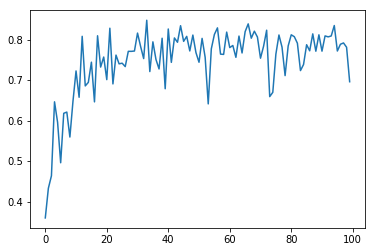

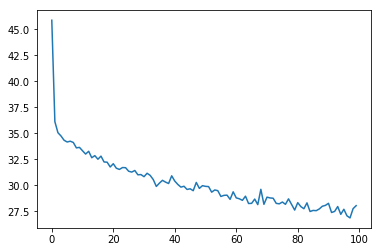

In [15]:
# Rysowanie lossu i AUC

import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

# Zapis Predykcji

In [16]:
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('submission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [6]:
# Wczytanie najlepszego modelu
clf.load_state_dict(torch.load('tmp_model.pt'))

# Tworzenie data loadera testowego
X_test_tensor = torch.Tensor(X_test).unsqueeze(1)

test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

# Ewaluacja modelu na danych testowych
#TODO - create a threshold?
clf.eval()
preds = []
for X in test_data_loader:
    out = clf(X[0])
    preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
preds = np.concatenate(preds, axis = 0)


In [18]:


# Zapisanie predykcji do poprawnego formatu
save_predictions(preds)